# Sample processing

- This code creates input samples for InVEST model and the deep learning models
- Large scale geospatial data will be clipped into small patches for calculation and model training

In [9]:
import torch
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from IPython.display import display, clear_output

In [4]:
def get_expanded_grid(cell, expand_size=1280):
    # Find the center of the cell
    minx, miny, maxx, maxy = cell.bounds
    center_x = (minx + maxx) / 2
    center_y = (miny + maxy) / 2
    # Define the expanded box around the center
    expanded_bounds = box(
        center_x - expand_size,
        center_y - expand_size,
        center_x + expand_size,
        center_y + expand_size
    )
    return expanded_bounds.bounds
# Create a new column for storing bounds in the GeoDataFrame using Dask

def assign_bounds(grid_row):
    # Expand the grid
    expanded_grid = get_expanded_grid(grid_row.geometry)
    # Store the expanded bounds as a tuple
    bounds = expanded_grid.bounds
    # Return the original row with the bounds as an additional column
    grid_row['bounds'] = bounds
    return grid_row

In [19]:
# Set the working directory to the location of the script
os.chdir('E:/Coding/CNN_InV_ReOrg')
# Load rasters as rio xarrays, all should be in the same CRS, same resolution
lulc = rxr.open_rasterio("Rasters/MD5mLULCcom.tif") # Land Use Land Cover data
et0 = rxr.open_rasterio("Rasters/et0_v3_yrclipped5m.tif") # Evapotranspiration data
pop = rxr.open_rasterio("Rasters/md_pop_2020_5mbili32618.tif") # Population data
# Load sample grids as a GeoDataFrame, the shapefile should be in the same CRS as the rasters
samples = gpd.read_file('Sample/Samplefishnets_32618.shp') # Load the sample grid shapefile
# Calculate the bounds for each sample grid and store them in a new column, adjust the expand size as needed
samples['bounds'] = samples.geometry.apply(lambda geom: get_expanded_grid(geom))

# Test Plot
- Test if the functions correctly clipped the data

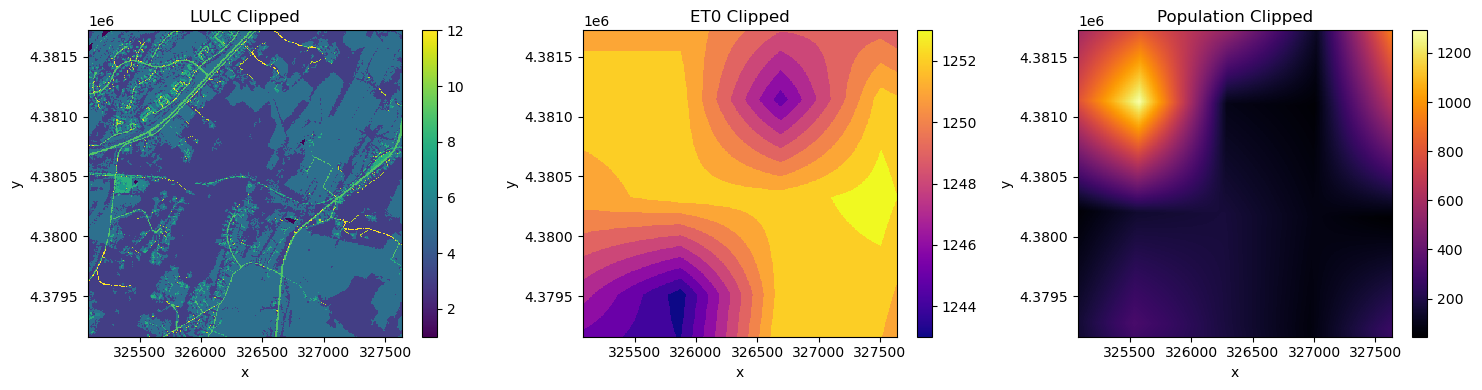

(1, 512, 512)


In [ ]:
# plot one sample
# Select a specific sample (e.g., the first one)
sample = samples.iloc[6657]
# Get the bounds (minx, miny, maxx, maxy) from the geometry
bounds = sample['bounds']

# Clip lulc raster
lulc_clipped = lulc.sel(
    x=slice(bounds[0], bounds[2]),
    y=slice(bounds[3], bounds[1])  # Note: Y coordinates are typically reversed
)

# Clip et0 raster
et0_clipped = et0.sel(
    x=slice(bounds[0], bounds[2]),
    y=slice(bounds[3], bounds[1])
)

# Clip pop raster
pop_clipped = pop.sel(
    x=slice(bounds[0], bounds[2]),
    y=slice(bounds[3], bounds[1])
)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plot lulc_clipped
lulc_clipped.plot(ax=axs[0], cmap='viridis')
axs[0].set_title('LULC Clipped')

# Plot et0_clipped
et0_clipped.plot(ax=axs[1], cmap='plasma')
axs[1].set_title('ET0 Clipped')

# Plot pop_clipped
pop_clipped.plot(ax=axs[2], cmap='inferno')
axs[2].set_title('Population Clipped')

plt.tight_layout()
plt.show()
# check the shape of the clipped rasters, in this case they should be 1x512x512
# print(lulc_clipped.shape)
# print(et0_clipped.shape)
# print(pop_clipped.shape)


## Clipping samples
- Clip the raster data into samples for later InVEST calculation and model Training

In [15]:
samples

,id,left,top,right,bottom,row_index,col_index,geometry,bounds
0,1.0,1396615.0,2037742.0,1399175.0,2035182.0,0.0,0.0,"POLYGON ((129731.588 4464720.376, 132253.373 4...","(129425.95634053988, 4461918.4861773215, 13198..."
1,2.0,1396615.0,2035182.0,1399175.0,2032622.0,1.0,0.0,"POLYGON ((129158.54 4462243.835, 131680.391 44...","(128852.96193479639, 4459441.977544364, 131412..."
2,3.0,1396615.0,2032622.0,1399175.0,2030062.0,2.0,0.0,"POLYGON ((128585.532 4459767.312, 131107.45 44...","(128280.00773050004, 4456965.486843675, 130840..."
3,4.0,1396615.0,2030062.0,1399175.0,2027502.0,3.0,0.0,"POLYGON ((128012.565 4457290.807, 130534.549 4...","(127707.09394609663, 4454489.013593127, 130267..."
4,5.0,1396615.0,2027502.0,1399175.0,2024942.0,4.0,0.0,"POLYGON ((127439.639 4454814.319, 129961.688 4...","(127134.22079978712, 4452012.557311056, 129694..."
5,6.0,1396615.0,2024942.0,1399175.0,2022382.0,5.0,0.0,"POLYGON ((126866.754 4452337.848, 129388.867 4...","(126561.38850953011, 4449536.117516279, 129121..."
6,7.0,1396615.0,2022382.0,1399175.0,2019822.0,6.0,0.0,"POLYGON ((126293.91 4449861.392, 128816.087 44...","(125988.59729304136, 4447059.693728063, 128548..."
7,8.0,1396615.0,2019822.0,1399175.0,2017262.0,7.0,0.0,"POLYGON ((125721.107 4447384.953, 128243.349 4...","(125415.84736779088, 4444583.285466161, 127975..."
8,9.0,1396615.0,2017262.0,1399175.0,2014702.0,8.0,0.0,"POLYGON ((125148.346 4444908.529, 127670.651 4...","(124843.13895101249, 4442106.892250771, 127403..."
9,10.0,1396615.0,2014702.0,1399175.0,2012142.0,9.0,0.0,"POLYGON ((124575.627 4442432.119, 127097.995 4...","(124270.4722596952, 4439630.513602566, 126830...."


In [13]:
# Output folder
output_folder = 'Prosd'
os.makedirs(output_folder, exist_ok=True)

In [ ]:
# Only a subset of samples for testing
samples = samples.iloc[1007:1017]  # Use select the 10 samples for testing

idx_null = []
# Use the Mask Directly from the GeoDataFrame to save tensors
for idx, grid in samples.iterrows():
    try:
        # Get the bounds from the GeoDataFrame
        bounds = grid['bounds']

        # Apply the bounds to select the road raster
        lulc_clipped = lulc.sel(
            x=slice(bounds[0], bounds[2]),
            y=slice(bounds[3], bounds[1])
        )
        et0_clipped = et0.sel(
            x=slice(bounds[0], bounds[2]),
            y=slice(bounds[3], bounds[1])
        )
        pop_clipped = pop.sel(
            x=slice(bounds[0], bounds[2]),
            y=slice(bounds[3], bounds[1])
        )
        # Default nodata value for lulc is 255, and value 254 is APG, these values are not needed for model training
        # replace value 254 and 255 in lulc_clipped to null, exclude samples containing these values
        lulc_clipped = lulc_clipped.where((lulc_clipped != 254) & (lulc_clipped != 255), np.nan)
        if np.any(np.isnan(lulc_clipped.values)) or np.any(np.isnan(et0_clipped.values)) or np.any(np.isnan(pop_clipped.values)):
            idx_null.append(idx)
            continue
        else:
            merge_array = np.stack([lulc_clipped.values, et0_clipped.values, pop_clipped.values], axis=0)
            merge_tensor = torch.tensor(merge_array, dtype=torch.float32)


        # Save the tensor as a .pt file
        output_path = os.path.join(output_folder, f'{int(grid["id"])}.pt')
        torch.save(merge_tensor, output_path)
        print(f"Saved tensor for grid FID {grid['id']}")
    except Exception as e:
        print(f"Failed to clip and save for grid FID {grid['id']}: {e}")


Saved tensor for grid FID 1008.0
Saved tensor for grid FID 1009.0
Saved tensor for grid FID 1010.0
Saved tensor for grid FID 1011.0
Saved tensor for grid FID 1012.0
Saved tensor for grid FID 1013.0
Saved tensor for grid FID 1014.0
Saved tensor for grid FID 1015.0
Saved tensor for grid FID 1016.0
Saved tensor for grid FID 1017.0
